In [1]:
%matplotlib notebook
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from itertools import product
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm_notebook as tqdm

In [2]:
sx = np.array([[0, 1], [1, 0]], complex)
sy = np.array([[0 , -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]], complex)
s0 = np.array([[1, 0], [0, 1]], complex)
eye = np.eye(4)

def hamiltonian(mJ, k, mu, alpha, R, n, dn):
    """
    Parameters:
    mJ ... angular momentum sector
    k ... momentum
    mu ... chemical potential
    alpha ... spin-orbit coupling
    R ... radius
    n ... winding of superconducting order parameter
    dn ... correction to effective winding due to flux: phi = n + dn
    Returns: 
    Hamiltonian
    """
    L = mJ * eye - 0.5 * np.kron(s0, sz) - 0.5 * (n + dn) * np.kron(sz, s0)
    kinetic = ((k**2 - mu) * eye + (1/R**2) * L.dot(L)).dot(np.kron(sz, s0))
    pairing = np.kron(sx, s0)
    spinorbit = alpha * k * np.kron(sz, sy) - (alpha / R) * np.kron(sz, sz).dot(L)
    return kinetic + pairing + spinorbit

def find_gap_and_pfaffian(mu, alpha, R, n, dn, MAX):
    """
    Parameters:
    mu ... chemical potential
    alpha ... spin-orbit coupling
    R ... radius
    n ... winding of superconducting order parameter
    dn ... correction to effective winding due to flux: phi = n + dn
    MAX ... highest angular momentum sector considered
    Returns: 
    dict containing smallest gap and pfaffian
    """
   
    if n % 2 == 0:
        mJs = np.arange(MAX + 1) + 0.5
    else:
        mJs = np.arange(MAX + 1)
    ks = np.linspace(0, 2 * np.sqrt(mu), 500)
   
    gaps = np.zeros((len(mJs), len(ks)))
    for (i, mJ) in enumerate(mJs):
        for (j, k) in enumerate(ks):
            ham = hamiltonian(mJ, k, mu, alpha, R, n, dn)
            gaps[i, j] = np.min(np.abs(np.linalg.eigvalsh(ham)))
    
    phi = n+dn
    MU = lambda mJ: mu - 0.5 * (alpha / R) - 0.25 * (1 / R**2) * (4 * mJ**2 + 1 + phi**2)
    VZ = lambda mJ: 0.5 * phi * ((alpha / R) + (1 / R**2)) 
    AA = lambda mJ: - phi * mJ / R**2
    CC = lambda mJ: - mJ * ((alpha / R) + (1 / R**2))
           
    pfaffian = 1
    for mJ in np.unique(np.hstack((-mJs, mJs))):
        pf = np.sign(1 + (CC(mJ)-MU(mJ))**2 - (AA(mJ) + VZ(mJ))**2)
        pfaffian *= pf
   
    return dict(mingap=np.min(gaps), pfaffian=pfaffian)

In [3]:
pars = dict(
    alpha = np.linspace(-0.5, 2.5, 31),
    mu = np.linspace(0, 4, 31),
    R = [0.5],
    n = [1],
    MAX = [5],
    dn = [-0.5],
            )
par_list = [{k: v for k, v in zip(pars.keys(), vs)} for vs in product(*pars.values())]

In [4]:
result_list = []

with ProcessPoolExecutor() as ex:
    futs = [ex.submit(find_gap_and_pfaffian, **args) for args in tqdm(par_list)]
    for keys, fut in zip(par_list, tqdm(futs)):
        result = dict(keys)
        result.update(fut.result())
        result_list.append(result)
        
df = pd.DataFrame(result_list)

<IPython.core.display.Javascript object>


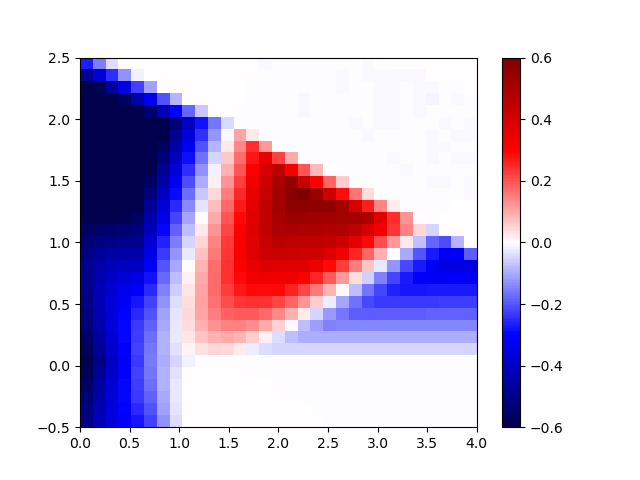

In [5]:
data1 = df.pivot(index='alpha', columns='mu', values='pfaffian')
data2 = df.pivot(index='alpha', columns='mu', values='mingap')

plt.figure()
plt.imshow(-data2.values[::-1, :]*data1.values[::-1, :], extent=[data1.columns[0], data1.columns[-1], data1.index[0], data1.index[-1]], cmap='seismic', vmin=-0.6, vmax=0.6, aspect='auto')
plt.colorbar()

In [6]:
pars = dict(
    alpha = np.linspace(-0.5, 2.5, 31),
    mu = [2.],
    R = [0.5],
    n = [1],
    MAX = [5],
    dn = np.linspace(-1., -0.4, 31),
            )
par_list = [{k: v for k, v in zip(pars.keys(), vs)} for vs in product(*pars.values())]

In [7]:
result_list = []

with ProcessPoolExecutor() as ex:
    futs = [ex.submit(find_gap_and_pfaffian, **args) for args in tqdm(par_list)]
    for keys, fut in zip(par_list, tqdm(futs)):
        result = dict(keys)
        result.update(fut.result())
        result_list.append(result)
        
df = pd.DataFrame(result_list)

<IPython.core.display.Javascript object>


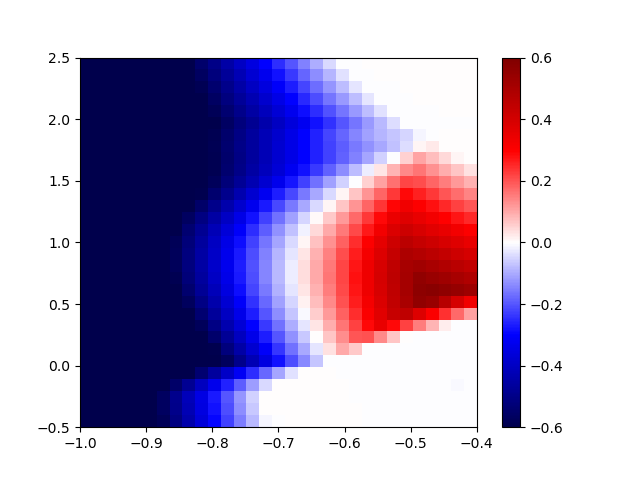

In [8]:
data1 = df.pivot(index='alpha', columns='dn', values='pfaffian')
data2 = df.pivot(index='alpha', columns='dn', values='mingap')

plt.figure()
plt.imshow(-data2.values[:, :]*data1.values[:, :], extent=[data1.columns[0], data1.columns[-1], data1.index[0], data1.index[-1]], cmap='seismic', vmin=-0.6, vmax=0.6, aspect='auto')
plt.colorbar()